## This notebook contains routines to analyze the electric load profiles from PG&E office building
#### Brief description of this workflow:
1. Pre-processing (skip this step your if you have cleaned data)
    - Extract data for a building type (e.g. office building in our case)
    - Remove empty and problematic data
    - Convert data into dataframes ([example](../data_all/1004541105.csv))
    - Get typical building load profiles
        - Create annual heatmaps
        - Use pre-trained CNN model and k-means clustering to distinguish typical building loads (high-load during daytime) and non-typical loads (e.g., high-load during night time)
2. Conduct Frequency-Domain analysis
    - Annual analysis
        - Create bins to group high, medium, and low frequency features
    - Daily analysis
        - How

### Setup the path and import utility libraries (Needed for first-time run)

In [1]:
%pwd
%cd ..

# Import utility functions
# Change directory to the EULP root path, use %cd path_to_EULP
import os
from lib import data_exploration_utils as ex
from lib import frequency_domain_utils as fd
dir_root = %pwd
dir_data = os.path.join(dir_root, "data_all")
dir_fig = os.path.join(dir_root, "fig")

/mnt/c/Users/hlee9/Documents/GitHub/DOE_EULP/EULP


Using TensorFlow backend.


### Step 1. Pre-processing (optional)
Previously, we found some load profiles have high-peak during the night time, we want to explore how those load profile look like and whether we should separate them from typical load profiles.

#### Generate heatmaps and time-series line plot for visualization

In [ ]:
v_ts_CSVs = ex.get_all_file_paths(dir_data, 'csv')
# Create these paths if not exist
dir_heatmaps = os.path.join(dir_fig, "ts_heatmaps")
dir_lines = os.path.join(dir_fig, "ts_lines")

v_valid_ts_CSVs = []
for i, ts_csv in enumerate(v_ts_CSVs):
    sp_id = os.path.basename(ts_csv).split('.')[0]
    df_t = ex.clean_pge_df_ts(ts_csv, 2015).dropna()
    df_t = df_t['Value'].squeeze()
    dir_heatmap = os.path.join(dir_heatmaps, f"{sp_id}.png")
    try:
        ex.generate_heatmap(df_t, dir_heatmap)
        ex.generate_ts_html(df_t, sp_id, dir_lines)
        v_valid_ts_CSVs.append(ts_csv)
    except:
        pass

#### Apply k-means clustering with features generated from pre-trained CNN model

In [13]:
# Get conv base features
v_heatmaps = ex.get_all_file_paths(dir_heatmaps, 'png')
model_conv_base = ex.model_vgg16_conv_base()
v_conv_base_features = [ex.get_conv_base_features(img, model_conv_base).flatten() for img in v_heatmaps]

In [14]:
# Clustering (k=2 because we already know there are two distinct patterns) 
from sklearn.cluster import KMeans
kmeans_step_1 = KMeans(n_clusters=2, random_state=0).fit(v_conv_base_features)

In [16]:
# Copy heatmaps to corresponding cluster folder for comparison
import shutil
kmeans_labels_step_1 = kmeans_step_1.labels_
step_1_out_dir = os.path.join(dir_fig, 'step_1')

for i, label in enumerate(kmeans_labels_step_1):
    cluster_dir = os.path.join(step_1_out_dir, f"cluster_{label}")
    if not os.path.exists(cluster_dir):
        os.mkdir(cluster_dir)
    shutil.copy(v_heatmaps[i], cluster_dir)

In [17]:
# Get the "typical" load profiles
import numpy as np
v_typical_ts_CSVs = list(np.take(v_valid_ts_CSVs, np.where(kmeans_labels_step_1==1))[0]) # Caution: cluster label might be 0 for typical load profiles
v_typical_heatmaps = list(np.take(v_heatmaps, np.where(kmeans_labels_step_1==1))[0])

### Step 2. Frequency-domain analysis

#### Get frequency-domain features at daily window level.

The Dicrete Fourier Transform (DFT) of a daily load profile (15-min interval, 96 timestamps in total) may yield a spectrum with the frequency ranging from 0.5 hour to 12 hour. However, different load profiles may have different peaks in the spectrums. Creating bins of frequencies allows us to group various spectrum peaks. First, we're going to explore the load profiles' variations within each day. We do the following for each building:
1. Run DFT for each day
2. Group the frequency spectrum features into hour-interval bins, sum the amplitudes in each bin. 
3. Explore the distributions of the amplitude sums in each bin

In this case, we define the following hour interval bins.

In [2]:
hour_interval_bins = [
    [0.5, 0.75],
    [0.75, 1],
    [1, 1.25],
    [1.25, 1.5],
    [1.5, 1.75],
    [1.75, 2],
    [2, 4],
    [4, 8],
    [8, 12]
]

fd.print_hour_interval_bin_info(hour_interval_bins)

= = = = = = = = = = = = = = = = = = = = 
Bin 1: 0.00037 Hz to 0.00056 Hz
Bin 2: 0.00028 Hz to 0.00037 Hz
Bin 3: 0.00022 Hz to 0.00028 Hz
Bin 4: 0.00019 Hz to 0.00022 Hz
Bin 5: 0.00016 Hz to 0.00019 Hz
Bin 6: 0.00014 Hz to 0.00016 Hz
Bin 7: 7e-05 Hz to 0.00014 Hz
Bin 8: 3e-05 Hz to 7e-05 Hz
Bin 9: 2e-05 Hz to 3e-05 Hz
= = = = = = = = = = = = = = = = = = = = 


Prepare the data. An example normalized load profile look like below.

In [3]:
import pandas as pd

dir_typical_ts_CSVs = '/mnt/c/Users/hlee9/Documents/GitHub/DOE_EULP/EULP/data_all/valid_CSVs'
dir_daily_window_dft_out = '/mnt/c/Users/hlee9/Documents/GitHub/DOE_EULP/EULP/fig/step_2'

v_typical_ts_CSVs = ex.get_all_file_paths(dir_typical_ts_CSVs, 'csv')

csv_in = v_typical_ts_CSVs[1]
df_ts = ex.clean_pge_df_ts(csv_in, 2015).dropna()
df_ts

,Value,date
Datetime,,
2015-01-01 00:00:00,0.046144,2015-01-01
2015-01-01 00:15:00,0.061305,2015-01-01
2015-01-01 00:30:00,0.009888,2015-01-01
2015-01-01 00:45:00,0.007910,2015-01-01
2015-01-01 01:00:00,0.018457,2015-01-01
...,...,...
2015-12-31 22:45:00,0.000000,2015-12-31
2015-12-31 23:00:00,0.000000,2015-12-31
2015-12-31 23:15:00,0.000000,2015-12-31


Below is an frequency spectrum bins example for one building.

,0.5hr ~ 0.75hr,0.75hr ~ 1hr,1hr ~ 1.25hr,1.25hr ~ 1.5hr,1.5hr ~ 1.75hr,1.75hr ~ 2hr,2hr ~ 4hr,4hr ~ 8hr,8hr ~ 12hr
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.062305,0.035666,0.023685,0.013913,0.009762,0.009295,0.030751,0.016197,0.006820
std,0.040897,0.022096,0.015163,0.008324,0.006567,0.006031,0.022160,0.013399,0.010964
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.037751,0.026402,0.017381,0.010442,0.007096,0.006628,0.024805,0.011331,0.001824
50%,0.068710,0.038847,0.025609,0.015500,0.010192,0.009811,0.033683,0.017288,0.004879
75%,0.090238,0.048179,0.030797,0.018739,0.013130,0.012480,0.038285,0.019319,0.007288
max,0.272892,0.171713,0.115181,0.048356,0.045471,0.034547,0.209570,0.106699,0.096793


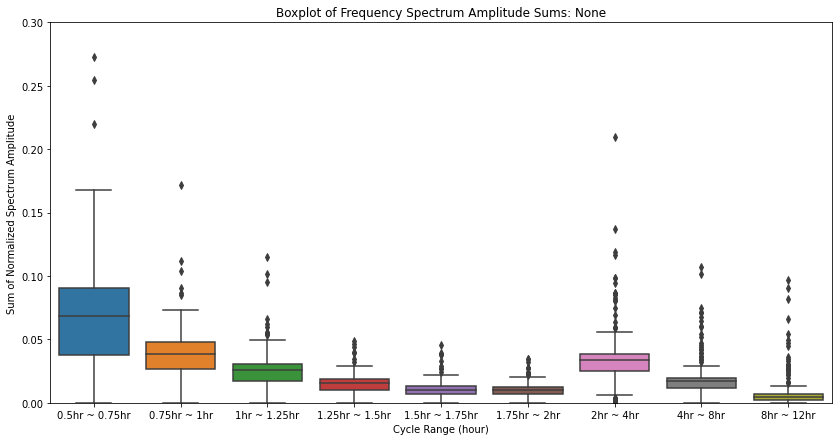

In [4]:
df = fd.get_daily_fft_sum_bins(df_ts, hour_interval_bins)
fd.daily_fft_sum_bins_boxplot(df)
df.describe()

Generate the frequency sprectrum bins for each building, save the boxplot.

In [5]:
len(v_typical_ts_CSVs)

188

In [ ]:
for i, ts_csv in enumerate(v_typical_ts_CSVs):
    print(dir_daily_window_dft_out)
    sp_id = os.path.basename(ts_csv).split('.')[0]
    df_ts = ex.clean_pge_df_ts(ts_csv, 2015).dropna()
    df = fd.get_daily_fft_sum_bins(df_ts, hour_interval_bins)
    fd.daily_fft_sum_bins_boxplot(df, title_key=sp_id, save_path=f"{dir_daily_window_dft_out}/{sp_id}.png")